In [1]:
from pandas import read_sql_query, read_sql_table

import pandas as pd
import sqlite3
from matplotlib import pyplot as plt
import datetime

import requests
import json

In [2]:
# Старая функция чтения базы

def read_sqlite(dbfile):
    with sqlite3.connect(dbfile) as dbcon:
        tables = list(read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", dbcon)['name'])
        out = {tbl : read_sql_query(f"SELECT * from {tbl}", dbcon) for tbl in tables}
    
    return out

def add_time_to_df(df, time_colname='time'):
    for i, row in df.iterrows():
        df['dt'] = df[time_colname].apply(lambda x: datetime.datetime.fromtimestamp(x))
        return df

In [18]:
def get_xy_from_db(token, db_fp = 'bd.sqlite'):
    sql_data = read_sqlite(db_fp)
    
    d = sql_data['futures']
    d = add_time_to_df(d, time_colname='time')
    d_filetered = d[d['coin']==token]

    x = d_filetered['dt']
    y = d_filetered['mean']
    
    return x, y

def get_xy_from_api(token, start, end):
    # Alternative:
    req = f'https://futures.mexc.com/api/v1/contract/kline/{token}?end={end}&interval=Min15&start={start}'
    # req = 'https://futures.mexc.com/api/v1/contract/detail'
    answer = requests.get(req)
    data = json.loads(answer.text)['data']
    df = pd.DataFrame(data)
    df = add_time_to_df(df)
    return df['dt'], df['open']

In [34]:
token = 'AIL_USDT'

##### POINTS DATA
db_fp = 'db.sqlite3'
sql_data = read_sqlite(db_fp)

p = sql_data['monitoring_app_tradingpair']

coin_id = p[p['symbol']==token].id.tolist()[0]  # 

k = sql_data['monitoring_app_event']
g = add_time_to_df(k, time_colname='event_time')
c = g[g['trading_pair_id']==coin_id]

if not c.shape[0]:
    print("Data not exist")
else:
    pstarts = c[c['event_type']=='pump_start'].sort_values(by='event_time').reset_index()
    pends = c[c['event_type']=='pump_end'].sort_values(by='event_time').reset_index()
    
    start, end = (int(pstarts.iloc[0]['event_time']), int(pends.iloc[-1]['event_time'])) #  int(datetime.datetime.now().timestamp()))
    
    ##### MINUTE DATA
    
    # x,y = get_xy_from_db(token, start, end)
    x,y = get_xy_from_api(token, start, end)

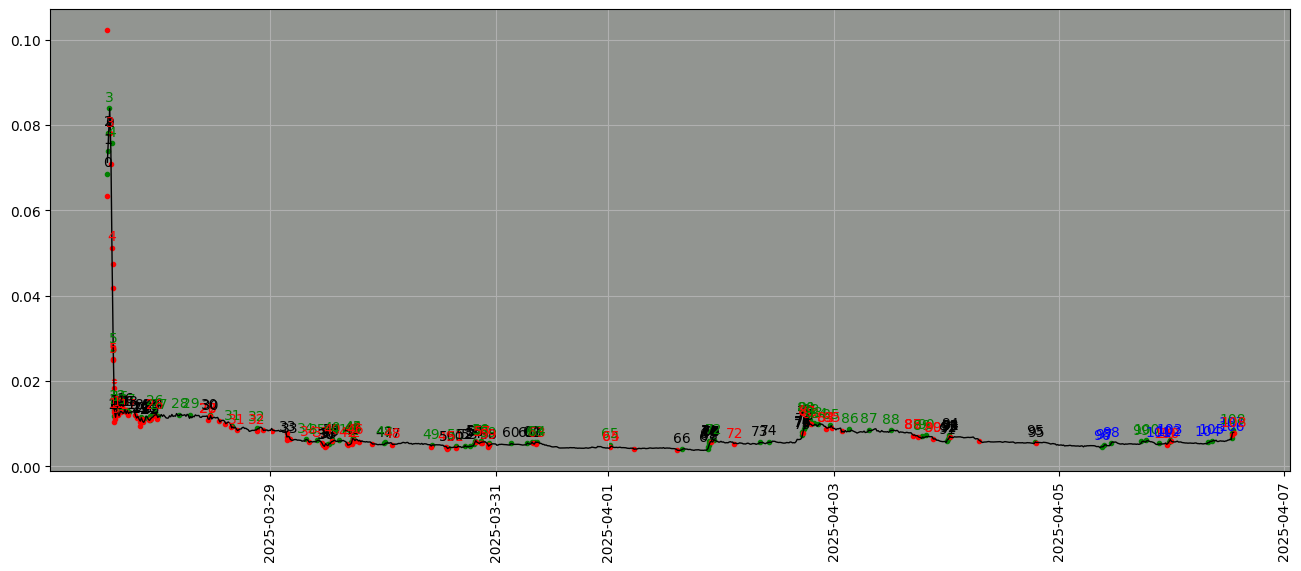

In [35]:
plt.figure(figsize=(16,6))
ax = plt.gca()
ax.set_facecolor('xkcd:gray')

x1, y1 = (pstarts['dt'], pstarts['event_price'])
x2, y2 = (pends['dt'], pends['event_price'])

plt.scatter(x1, y1, color='g', marker='.')
plt.scatter(x2, y2, color='r', marker='.')
# plt.plot(df['dt'], df['open'], color='black', linewidth=1)
plt.plot(x, y, color='black', linewidth=1)


# now = time.time()
fifteen_minutes_ago = 15 * 60
three_hours_ago = 3 * 3600
one_day_ago = 24 * 3600

pump_starts = pstarts
pump_ends = pends
# pair = await get_or_create_trading_pair(symbol)
# pump_starts = await get_pump_starts(pair)
# pump_ends = await get_pump_ends(pair)

now = pends.iloc[-1].event_time
cur_price = pends.iloc[-1].event_price
cur_i = 0

stats = {
    "fifteen_minutes": 0,
    "three_hours": 0,
    "one_day": 0,
    "more_one_day": 0,

    "profit_deals_cnt": 0,   # int: кол-во сделок в плюс
    "loss_deals_cnt": 0,     # int: кол-во сделок в минус
    "profit_percentage": 0,  # float: накопление профита в % чистого движения
    "loss_percentage": 0,    # float: накопление лосса в % чистого движения
    "in_deal_cnt": 0,        # int: кол-во сделок в отработке
    "in_deal_percentage": 0, # int: баланс сделки в отработке
}

for psi, pstart in pump_starts.iterrows():
    is_positive_deal = True
    diff_percent = 0
    next_pend = None
    non_closed = False
    loss_day_closed_price = 0
    for pei, pend in pump_ends.iterrows():
        if pend.event_time > pstart.event_time:
            # check if price lower thr
            if pend.event_price <= pstart.event_price*0.93:
                next_pend = pend
                break
            # check if price higher thr and got more one day
            elif now - pend.event_time >= one_day_ago:
                loss_day_closed_price = pend.event_price
                break
    # got win deal or got more one day loss deal
    if next_pend is not None:
        # deals emulation stats
        diff_percent = round((next_pend.event_price - pstart.event_price) / pstart.event_price * 100, 1)
        # timing stats
        if next_pend.event_time - pstart.event_time >= one_day_ago:
            stats["more_one_day"] += 1
            is_positive_deal = False
        elif next_pend.event_time - pstart.event_time >= three_hours_ago:
            stats["one_day"] += 1
        elif next_pend.event_time - pstart.event_time >= fifteen_minutes_ago:
            stats["three_hours"] += 1
        elif next_pend.event_time - pstart.event_time < fifteen_minutes_ago:
            stats["fifteen_minutes"] += 1
    # got current deal or current deal lasts more one day
    else:
        #  loss deal (lasts more one day and closed in minus for damp price)
        if loss_day_closed_price:
            is_positive_deal = False
            diff_percent = round((loss_day_closed_price - pstart.event_price) / pstart.event_price * 100, 1)
            stats["more_one_day"] += 1
        # deal lasts less one day and not closed
        else:
            non_closed = True
            # calculate difference of current price
            diff_percent = round((cur_price - pstart.event_price) / pstart.event_price * 100, 1)
            # adjust relevant value of percentage
            stats["in_deal_cnt"] += 1
            # pump loss deal
    if non_closed:
        stats["in_deal_percentage"] += diff_percent
        plt.annotate(cur_i, (x1[psi], y1[psi]), textcoords="offset points", xytext=(0, 5), ha='center', color='b')
    # profit deal
    elif is_positive_deal:

        plt.annotate(cur_i, (x1[psi], y1[psi]), textcoords="offset points", xytext=(0, 5), ha='center', color='g')
        plt.annotate(cur_i, (x2[pei], y2[pei]), textcoords="offset points", xytext=(0, 5), ha='center', color='r')
        
        stats['profit_deals_cnt'] += 1
        stats['profit_percentage'] += abs(diff_percent)
    # loss deal (lasts more one)
    elif not is_positive_deal:
        plt.annotate(cur_i, (x1[psi], y1[psi]), textcoords="offset points", xytext=(0, 5), ha='center', color='black')
        plt.annotate(cur_i, (x2[pei], y2[pei]), textcoords="offset points", xytext=(0, 5), ha='center', color='black')
        stats['loss_deals_cnt'] += 1
        stats['loss_percentage'] += abs(diff_percent)
    cur_i +=1

plt.xticks(rotation=90)
plt.grid()
plt.show()